### Packages

In [1]:
# basic 
import pandas as pd 
import numpy as np

# Files
import glob
import os 

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Graphes 
from graph_tool.all import *

# Scikit-Learn 
from sklearn.preprocessing import LabelEncoder

In [2]:
# Répertoire de tavail

os.chdir("/home/nbernard/Documents/data/f_import")

# Import 

In [3]:
def aggregate_csv():
    """
    Concatene les csv présents dans le répertoire courant, 
    Renvoie un pandas DF résultant de la concaténation
    
    """
    extension = 'csv'
    all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
    combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')
    return(combined_csv)

In [4]:
def format_as_tgraph(data):
    """
    Formatage d'un pandas DF en un pandas DF adapté
    à un import en graphe de transactions: 
    
    Renvoie un pandas DF dans un format adapté a un import graphique
    
    """
    
    # On transforme les addresses en str pour éviter les ennuis
    data[['from_address', 'to_address']] = data[['from_address', 'to_address']].astype(str)

    
    # On concatene les addresses pour éviter les doublons 
    
    full_addresses = np.append(data['from_address'].values,data['to_address'].values)
    
    
    # Encodage des addresses sur la liste ENTIERE des addresses 
    Encoder = LabelEncoder()
    Encoder.fit(full_addresses) #Apprend sur les addresses 

    new_from = Encoder.transform(data['from_address']) # On transforme
    new_to = Encoder.transform(data['to_address'])     # On transforme
    
    
    # Remplacement des colonnes par les colonnes ainsi encodées
    data['from_address'] = new_from
    data['to_address'] = new_to
    
    # On transforme la colonne value en float
    data[['value']] = data[['value']].astype(float)
    
    
    return(data,Encoder)

In [5]:
def create_graph_obj(data):
    """
    Prend un pandas DF formaté correctement en transaction graph
    Crée et renvoie un objet graph-tool sur lequel on peut travailler
    
    """
    
    # Création du graphe vide
    g = Graph(directed=True) 

    # Ajout des arêtes suivant le np.array
    vmap = g.add_edge_list(data[['from_address','to_address']].values)

    # Ajout des edge weights 
    ew = g.new_edge_property("double")
    ew.a = data['value'].values
    g.ep['edge_weight'] = ew
    
    return(g)



Une première routine simple est la suivante: 

1) On appelle d'abord aggregate_csv() afin d'importer l'ensemble des fichiers csv du répertoire de travail

2) On appelle ensuite format_as_tgraph afin de formater le tableau renvoyé dans un format adéquat à l'importation sur graph_tool 

3) Enfin, on appelle create_graph_obj afin de créer le graph 

In [6]:
data = aggregate_csv()

In [7]:
data.head()

,hash,nonce,block_hash,block_number,transaction_index,from_address,to_address,value,gas,gas_price,input
0,0xccf7d1baf83f55478ee8f00261721c9a949b10c04011...,20,0x9ac5945c38ea29a02091c158a1ab36efaf1c8e362d96...,1980101,0,0x4dde2abecb50d9ac38d0962752c139c17e6f7b84,0x91337a300e0361bddb2e377dd4e88ccb7796663d,249969580000000000000,21000,20000000000,0x
1,0x15648f9c80b2f057e1b4dac252a7a16f1cd8475d57cd...,12176,0x47bf0fa3153eaaeba2cf9a83a11c20b96aa42f8f03ff...,1980105,0,0xfbe26da0e985087d28228defbdaa394713b0865f,0x16f6eb1b7f5bd05b4eb9b9dbd47a68cf2af70b25,1011282722474936,21000,40000000000,0x
2,0x40f3394aa7700b8c32ae9b64b016512d956b28b03d78...,14,0x47bf0fa3153eaaeba2cf9a83a11c20b96aa42f8f03ff...,1980105,1,0xd60990b33e8e76ef82bd8a109d4ca812711bbfdd,0x91337a300e0361bddb2e377dd4e88ccb7796663d,2074330340000000000,21000,20000000000,0x
3,0xc47c1389ffb82a538bd49505c0487d9f6043698e4baf...,47,0x47bf0fa3153eaaeba2cf9a83a11c20b96aa42f8f03ff...,1980105,2,0x5fdc8094d5ca2e85388ee66261bc8eeef9611f17,0x91337a300e0361bddb2e377dd4e88ccb7796663d,87849600000000000,21000,20000000000,0x
4,0xeaa9e826d6cbfd4e111865d3524db2ee95ba84689b93...,31,0x47bf0fa3153eaaeba2cf9a83a11c20b96aa42f8f03ff...,1980105,3,0x2bd11f1cf852c72b3f4fad56afc4c8aaa5c7afb1,0x91337a300e0361bddb2e377dd4e88ccb7796663d,1689580000000000000,21000,20000000000,0x


In [8]:
data,Encoder = format_as_tgraph(data)

In [9]:
g = create_graph_obj(data)

# Premiers indicateurs naïfs

## Avec l'écart interquartile $\tau_{iq}$

Dans cette partie, on veut commencer de manière naïve par repérer les addresses constituant des outliers selon plusieurs critères.

On fixe un paramètre $\lambda=1,5$  par défaut (éventuellement modifiable) et on mesure l'écart interquartile $\tau_{iq} = q_{3/4} - q_{1/4}$ .


Si l'observation $x$ est telle que $x > q_{3/4} + \lambda\tau_{iq}$ ou bien $x < q_{1/4} - \lambda\tau_{iq}$, alors on considère que $x$ est un outlier.


Dans le cas particulier des graphes, puisque les critères ne prennent pas de valeurs négatives, on se contente de vérifier la première inégalité.

In [10]:
# Le montant des transactions 

def transaction_outlier(graph,coeff_lambda=1.5):
    """
    Prend en arguments le graphe de transactions à étudier, et lambda permettant d'ajuster le seuil 
    Renvoie les outliers selon le montant des transactions/eweights associés au graphe 
    sous forme d'un DF pandas 
    
    """
    g = graph
    ew = g.ep['edge_weight']
    
    # On récupère les poids 
    tweights = np.array(ew.a)
    
    # Ecart interquartile
    twq34 = np.quantile(tweights,3/4) # quantile 3/4
    twq14 = np.quantile(tweights,1/4) # quantile 1/4
    tauiq = twq34 - twq14
    
    # Seuillage
    treshold = twq34 + coeff_lambda*tauiq
    index = np.argwhere(tweights >  treshold) # Index des transactions outliers
    values = tweights[tweights > treshold]   # Montant des transactions outliers 
    
    # Préparation du tableau
    
    d_out_e = pd.DataFrame(index,columns=['e_index']) # tableau des arêtes outliers
    df_edges = pd.DataFrame(g.get_edges(),columns=['from','to','index']) # tableau complet des arêtes    
    
    d_out_e.set_index('e_index',inplace=True) # changement des index pour un inner join
    df_edges.set_index('index',inplace=True) # changement des index pour un inner join    
    
    df_edges_out = d_out_e.merge(df_edges,left_index=True,right_index=True) # jointure interieure
    
    
    # On réencode les adresses
    df_edges_out['from_address'] = Encoder.inverse_transform(df_edges_out['from'])
    df_edges_out['to_address'] = Encoder.inverse_transform(df_edges_out['to'])
    df_edges_out['value'] = values
    return(df_edges_out)       

#### Code OK normalement ! 

In [11]:
def between_outlier(graph,coeff_lambda=1.5,nodes=True):
    """
    Prend en arguments le graphe de transactions à étudier, et lambda permettant d'ajuster le seuil 
    Renvoie les outliers au sens de la centralité d'intermédiarité 
    sous forme d'un DF pandas 
    
    """
    g = graph
    
    # On récupère les centralités d'intermédiarité de chaque noeuds (bv) et chaque arête (be)
    bv, be = betweenness(g)
    
    # On récupère les valeurs dans un array numpy
    arraybv = np.array(bv.a)
    arraybe = np.array(be.a)
    
    if nodes:
        q34 = np.quantile(arraybv,3/4)
        q14 = np.quantile(arraybv,1/4)
        
        # Ecart interquartile
        tauiq = q34 - q14
        
        # Seuillage
        treshold  = q34 + coeff_lambda*tauiq
        outliers = arraybv[arraybv > treshold]
        outliers_index = np.argwhere([arraybv > treshold])[:,1]
        
        
        # On prépare le tableau 
        
        df = pd.DataFrame(outliers_index,columns=['v_index'])
        df['address'] = Encoder.inverse_transform(df['v_index'])
        df['betweeness'] = outliers
        
        return(df)
    
    else:

        q34 = np.quantile(arraybe,3/4)
        q14 = np.quantile(arraybe,1/4)
        
        # Ecart interquartile
        tauiq = q34 - q14
        
        # Seuillage
        treshold  = q34 + coeff_lambda*tauiq
        outliers = arraybe[arraybe > treshold]
        outliers_index = np.argwhere(arraybe > treshold)
        
        
        # On prépare le tableau   
        d_out_e = pd.DataFrame(outliers_index,columns=['e_index']) # tableau des arêtes outliers
        df_edges = pd.DataFrame(g.get_edges(),columns=['from','to','index']) # tableau complet des arêtes
        
        d_out_e.set_index('e_index',inplace=True) # changement des indexs pour un inner join
        df_edges.set_index('index',inplace=True) # changement des indexs pour un inner join
        
        df_edges_out = d_out_e.merge(df_edges,left_index=True,right_index=True) # jointure interieure
        
        # On réencode les adresses
        df_edges_out['from_address'] = Encoder.inverse_transform(df_edges_out['from'])
        df_edges_out['to_address'] = Encoder.inverse_transform(df_edges_out['to'])
        df_edges_out['betweeness'] = outliers
        
        return(df_edges_out)
    

#### Code OK normalement ! 

In [12]:
# La fréquence des transactions parallèles (même source, même destinataires)

def parallel_outlier(graph,coeff_lambda=1.5):
    """
    Prend en arguments le graphe de transactions à étudier, et lambda permettant d'ajuster le seuil 
    Renvoie les outliers au sens des transactions parallèles 
    sous forme d'un DF pandas 
    
    """
    g = graph
    
    # On récupère les arêtes parallèles et on stocke dans un numpy array
    
    para = label_parallel_edges(g)
    nb_para = np.array(para.a)
    
    # Ecart interquartile
    q34 = np.quantile(nb_para,3/4) # quantile 3/4
    q14 = np.quantile(nb_para,1/4) # quantile 1/4
    tauiq = q34 - q14
    
    # Seuillage
    treshold = q34 + coeff_lambda*tauiq
    outliers_index = np.argwhere(nb_para > treshold)
    outliers = nb_para[nb_para > treshold]
    
    
    
    # On prépare le tableau   
    d_out_e = pd.DataFrame(outliers_index,columns=['e_index']) # tableau des arêtes outliers
    df_edges = pd.DataFrame(g.get_edges(),columns=['from','to','index']) # tableau complet des arêtes
        
    d_out_e.set_index('e_index',inplace=True) # changement des indexs pour un inner join
    df_edges.set_index('index',inplace=True) # changement des indexs pour un inner join
        
    df_edges_out = d_out_e.merge(df_edges,left_index=True,right_index=True) # jointure interieure
        
    # On réencode les adresses
    df_edges_out['from_address'] = Encoder.inverse_transform(df_edges_out['from'])
    df_edges_out['to_address'] = Encoder.inverse_transform(df_edges_out['to'])
    df_edges_out['number_parallel_transactions'] = outliers
    
    return(df_edges_out)


#### Code OK normalement ! 

In [13]:
#tr_outliers = transaction_outlier(g,coeff_lambda=2)

In [14]:
#tr_outliers

In [15]:
#bet_outliers = between_outlier(g,coeff_lambda=2)

In [16]:
#bet_outliers

In [46]:
#par_outliers = parallel_outlier(g,coeff_lambda=2)

In [47]:
#par_outliers

# Avec la variance $\sigma$

De manière plus simple, si une observation $x$ est située à une distance supérieure est $3\sigma$ de la moyenne, alors elle peut être considérée comme aberrante.


On repère alors les $x$ tels que $|x - \mu | > 3\sigma$ où $\mu$ est la moyenne selon ce critère.

In [19]:
# Le montant des transactions 

def transaction_outlier2(graph,coeff_sigma=3):
    """
    Prend en arguments le graphe de transactions à étudier, et lambda permettant d'ajuster le seuil 
    Renvoie les outliers selon le montant des transactions/eweights associés au graphe 
    sous forme d'un DF pandas 
    
    """
    g = graph
    ew = g.ep['edge_weight']
    
    # On récupère les poids 
    tweights = np.array(ew.a)
    
    # Ecart interquartile
    mean = np.mean(tweights)
    std = np.std(tweights)
    
    # Seuillage
    treshold = mean + coeff_sigma*std
    index = np.argwhere(tweights >  treshold) # Index des transactions outliers
    values = tweights[tweights > treshold]   # Montant des transactions outliers 
    
    # Préparation du tableau
    
    d_out_e = pd.DataFrame(index,columns=['e_index']) # tableau des arêtes outliers
    df_edges = pd.DataFrame(g.get_edges(),columns=['from','to','index']) # tableau complet des arêtes    
    
    d_out_e.set_index('e_index',inplace=True) # changement des index pour un inner join
    df_edges.set_index('index',inplace=True) # changement des index pour un inner join    
    
    df_edges_out = d_out_e.merge(df_edges,left_index=True,right_index=True) # jointure interieure
    
    
    # On réencode les adresses
    df_edges_out['from_address'] = Encoder.inverse_transform(df_edges_out['from'])
    df_edges_out['to_address'] = Encoder.inverse_transform(df_edges_out['to'])
    df_edges_out['value'] = values
    return(df_edges_out)       

#### Code OK normalement ! 

In [20]:
def between_outlier2(graph,coeff_sigma=3,nodes=True):
    """
    Prend en arguments le graphe de transactions à étudier, et lambda permettant d'ajuster le seuil 
    Renvoie les outliers au sens de la centralité d'intermédiarité 
    sous forme d'un DF pandas 
    
    """
    g = graph
    
    # On récupère les centralités d'intermédiarité de chaque noeuds (bv) et chaque arête (be)
    bv, be = betweenness(g)
    
    # On récupère les valeurs dans un array numpy
    arraybv = np.array(bv.a)
    arraybe = np.array(be.a)
    

    
    if nodes:
        meanbv = np.mean(arraybv)
        stdbv = np.std(arraybv)
        

        
        # Seuillage
        treshold  = meanbv + coeff_sigma*stdbv
        outliers = arraybv[arraybv > treshold]
        outliers_index = np.argwhere([arraybv > treshold])[:,1]
        
        
        # On prépare le tableau 
        
        df = pd.DataFrame(outliers_index,columns=['v_index'])
        df['address'] = Encoder.inverse_transform(df['v_index'])
        df['betweeness'] = outliers
        
        return(df)
    
    else:

        meanbe = np.mean(arraybe)
        stdbe = np.std(arraybe)
        

        
        # Seuillage
        treshold  = meanbe + coeff_sigma*stdbe
        outliers = arraybe[arraybe > treshold]
        outliers_index = np.argwhere(arraybe > treshold)
        
        
        # On prépare le tableau   
        d_out_e = pd.DataFrame(outliers_index,columns=['e_index']) # tableau des arêtes outliers
        df_edges = pd.DataFrame(g.get_edges(),columns=['from','to','index']) # tableau complet des arêtes
        
        d_out_e.set_index('e_index',inplace=True) # changement des indexs pour un inner join
        df_edges.set_index('index',inplace=True) # changement des indexs pour un inner join
        
        df_edges_out = d_out_e.merge(df_edges,left_index=True,right_index=True) # jointure interieure
        
        # On réencode les adresses
        df_edges_out['from_address'] = Encoder.inverse_transform(df_edges_out['from'])
        df_edges_out['to_address'] = Encoder.inverse_transform(df_edges_out['to'])
        df_edges_out['betweeness'] = outliers
        
        return(df_edges_out)
    

#### Code OK normalement ! 

In [21]:
# La fréquence des transactions parallèles (même source, même destinataires)

def parallel_outlier2(graph,coeff_sigma=3):
    """
    Prend en arguments le graphe de transactions à étudier, et lambda permettant d'ajuster le seuil 
    Renvoie les outliers au sens des transactions parallèles 
    sous forme d'un DF pandas 
    
    """
    g = graph
    
    # On récupère les arêtes parallèles et on stocke dans un numpy array
    
    para = label_parallel_edges(g)
    nb_para = np.array(para.a)
    
    meanpara = np.mean(nb_para)
    stdpara = np.std(nb_para)
    
    
    
    
    
    # Seuillage
    treshold = meanpara + coeff_sigma*stdpara
    outliers_index = np.argwhere(nb_para > treshold)
    outliers = nb_para[nb_para > treshold]
    
    
    
    # On prépare le tableau   
    d_out_e = pd.DataFrame(outliers_index,columns=['e_index']) # tableau des arêtes outliers
    df_edges = pd.DataFrame(g.get_edges(),columns=['from','to','index']) # tableau complet des arêtes
        
    d_out_e.set_index('e_index',inplace=True) # changement des indexs pour un inner join
    df_edges.set_index('index',inplace=True) # changement des indexs pour un inner join
        
    df_edges_out = d_out_e.merge(df_edges,left_index=True,right_index=True) # jointure interieure
        
    # On réencode les adresses
    df_edges_out['from_address'] = Encoder.inverse_transform(df_edges_out['from'])
    df_edges_out['to_address'] = Encoder.inverse_transform(df_edges_out['to'])
    df_edges_out['number_parallel_transactions'] = outliers
    
    return(df_edges_out)


#### Code OK normalement ! 

In [22]:
tr_outliers = transaction_outlier2(g)

In [23]:
tr_outliers

,from,to,from_address,to_address,value
32,37767,16186,0xc70409e6554b819ba7854f54137794c17959cc2a,0x556b5712c2a7cc5506fbfa785b52536fb8243765,3.000000e+22
410,9586,29371,0x32be343b94f860124dc4fee278fdcbd38c102d88,0x9aaca65b3c02bf9fe004da8d5d4fcc93c9b450db,3.109602e+22
3264,3111,36646,0x0fa010ce0c731d3b628e36b91f571300e49dbeab,0xc12c1476c045043c4688d7668985d70a0f8741ae,1.259900e+22
5364,25875,41771,0x8846928d683289a2d11df8db7a9474988ef01348,0xdc25d2d9bc80a9fbf7a792170c555dbe37081266,1.633400e+22
5384,41771,47494,0xdc25d2d9bc80a9fbf7a792170c555dbe37081266,0xfa52274dd61e1643d2205169732f29114bc240b3,1.633400e+22
15575,20569,32259,0x6c882c27732cef5c7c13a686f0a2ea77555ac289,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,6.999900e+22
16490,38560,16766,0xcafb10ee663f465f9d10588ac44ed20ed608c11e,0x58ae42a38d6b33a1e31492b60465fa80da595755,2.500000e+22
16599,8082,38560,0x2a7f8fa32012ba83e77afa782fbc9267ab0967d5,0xcafb10ee663f465f9d10588ac44ed20ed608c11e,2.293865e+22
22759,14515,32259,0x4c760cd9e195ee4f2d6bce2500ff96da7c43ee91,0xaa1a6e3e6ef20068f7f8d8c835d2d22fd5116444,3.398990e+22
29037,34832,36343,0xb794f5ea0ba39494ce839613fffba74279579268,0xbfc39b6f805a9e40e77291aff27aee3c96915bdd,1.250000e+23


In [24]:
#bet_outliers = between_outlier2(g,nodes=False)

In [25]:
#bet_outliers

In [26]:
#par_outliers = parallel_outlier2(g)

In [27]:
#par_outliers

# Représentation avec filtrage des arêtes et des noeuds  

In [28]:
df_edges = pd.DataFrame(g.get_edges(),columns=['from','to','index'])

In [29]:
df_edges.set_index('index',inplace=True)

In [30]:
tmp_df = tr_outliers[[]]

In [31]:
tmp_df['val'] = tr_outliers.value.values

/home/nbernard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
tmp_df

,val
32,3.000000e+22
410,3.109602e+22
3264,1.259900e+22
5364,1.633400e+22
5384,1.633400e+22
15575,6.999900e+22
16490,2.500000e+22
16599,2.293865e+22
22759,3.398990e+22
29037,1.250000e+23


In [33]:
df_edges

,from,to
index,,
166304,1,16780
195882,2,21
4794,4,36004
99817,6,35121
188117,6,35121
53804,7,27520
70595,7,27520
236680,7,27520
117339,8,21


In [34]:
test = pd.concat([df_edges, tmp_df], axis=1, join='outer')

In [35]:
test = test.fillna(0)

In [36]:
test.val.values

array([0., 0., 0., ..., 0., 0., 0.])

In [37]:
# Comment créer une edge ppty? 
# On crée d'abord l'objet avec g.new_ep('<type>')
# On remplit l'attribut a de cet edge ppty
# On l'associe au graphe g 

tr_out = g.new_ep('double') 
tr_out.a = (test.val.values)*10**(-18)
g.ep['tr_out'] = tr_out

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:500: UserWarning: Unknown attribute: size
  warnings.warn("Unknown attribute: " + str(k), UserWarning)


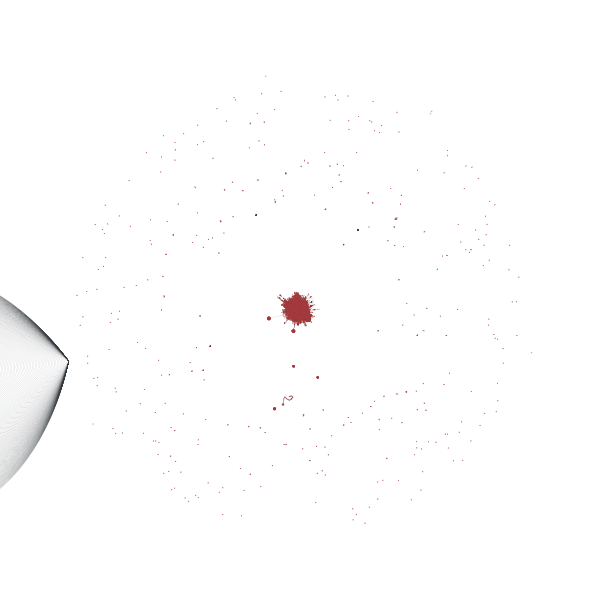

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f071d4c7cc0, at 0x7f06f56c07f0>

In [38]:
graph_draw(g,edge_size=tr_out)

In [39]:
g.get_vertices()

array([    0,     1,     2, ..., 48521, 48522, 48523], dtype=uint64)